<a href="https://colab.research.google.com/github/KendallScott/QTW/blob/main/Case%20Study%201/Case_Study_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn-intelex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearnex import patch_sklearn
patch_sklearn()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from tabulate import tabulate
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from numpy import arange
from sklearnex import patch_sklearn
from sklearn.linear_model import Lasso

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%201/train.csv') 
unique = pd.read_csv('https://raw.githubusercontent.com/KendallScott/QTW/main/Case%20Study%201/unique_m.csv') 
unique = unique.loc[:, unique.columns != 'critical_temp']
unique = unique.loc[:, unique.columns != 'material']

df=df.join(unique)

#dropping correlated values reference: https://www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python
corr_matrix = df.corr().abs()
corr_matrix

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# drop highly correlated features
df.drop(to_drop, axis=1, inplace=True)

<ipython-input-3-0f1f5981386c>:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Columns: 145 entries, number_of_elements to Rn
dtypes: float64(133), int64(12)
memory usage: 23.5 MB


In [5]:
# Make target and predictive datasets
y = df[['critical_temp']]
X = df.loc[:, df.columns != 'critical_temp']

Scaler = StandardScaler()
X_Scaled= Scaler.fit_transform(X)
X_Scaled = pd.DataFrame(X_Scaled, columns = X.columns)
y = pd.DataFrame(y)

In [6]:
# define grid
grid = dict()
grid['alpha'] = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1.01, 0.01)

#define the search
regr = ElasticNet(random_state=0)
cv = 5
search = GridSearchCV(regr, grid, scoring = 'neg_mean_absolute_error', cv=cv, n_jobs=-1)

#perform the search
results = search.fit(X_Scaled, y)
# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

MAE: -14.251
Config: {'alpha': 0.1, 'l1_ratio': 0.74}


In [7]:
regr = ElasticNet(random_state=0, alpha=.1, l1_ratio= 0.74)

i=0

# Create a 10-fold cross-validation 
cv = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)

MAE = []

#i=0
for train, test in cv.split(X_Scaled, y):
    X_train, X_test = X_Scaled.iloc[train], X_Scaled.iloc[test]
    y_train, y_test = y.iloc[train], y.iloc[test]

    X_train, y_train = make_regression(n_features=2, random_state=0)
    
    regr.fit(X_Scaled, y)

    # Predict 
    y_pred_lin_reg = regr.predict(X_test)
  
    # Calculate  mean squared error
    lin_MAE_reg= metrics.mean_absolute_error(y_test, y_pred_lin_reg)

    i=i+1
    # Append to the list
    MAE.append(lin_MAE_reg)

    # Print the scores
    print(tabulate([[i, lin_MAE_reg, ]], 
               headers=['MAE']))

        MAE
--  -------
 1  12.8279
        MAE
--  -------
 2  12.4171
        MAE
--  -------
 3  13.5385
       MAE
--  ------
 4  12.955
        MAE
--  -------
 5  12.9521
        MAE
--  -------
 6  12.6641
        MAE
--  -------
 7  13.4323
        MAE
--  -------
 8  12.9171
        MAE
--  -------
 9  12.8899
        MAE
--  -------
10  13.1926


Text(0.5, 0.98, 'Cross-Validated Predictions Plot')

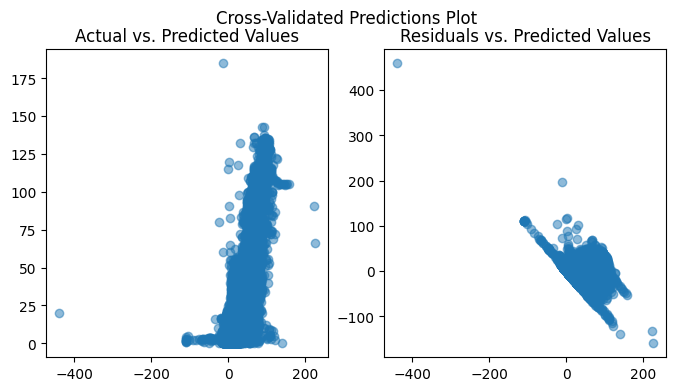

In [8]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(regr,X_Scaled,y,cv=10)

fig, axs = plt.subplots(ncols = 2,figsize = (8,4))
axs[0].scatter(x = y_pred, y = y,alpha = .5)
axs[0].set_title('Actual vs. Predicted Values')
axs[1].scatter(x = y_pred, y = (y.critical_temp - y_pred),alpha=.5)
axs[1].set_title('Residuals vs. Predicted Values')
fig.suptitle('Cross-Validated Predictions Plot')

Text(0.5, 0.98, 'Cross-Validated Predictions Plot')

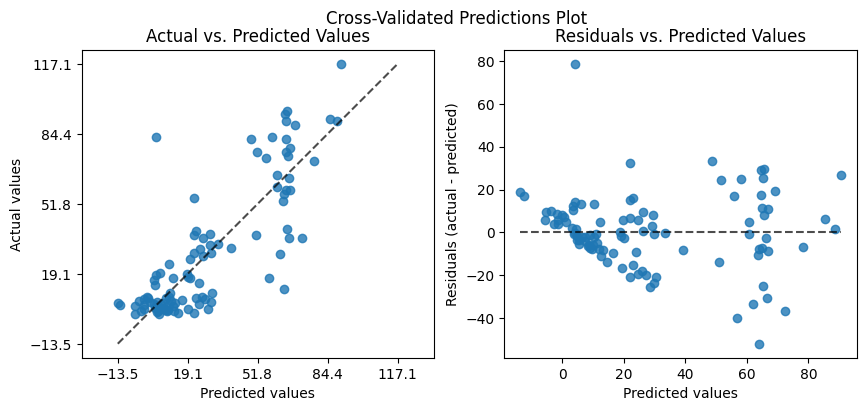

In [9]:
from sklearn.metrics import PredictionErrorDisplay
fig, axs = plt.subplots(ncols = 2, figsize = (10,4))
PredictionErrorDisplay.from_predictions(y.critical_temp
                                        ,y_pred=y_pred,
                                        kind="actual_vs_predicted",
                                        ax=axs[0],random_state=0,
                                        subsample = 100)
axs[0].set_title('Actual vs. Predicted Values')
PredictionErrorDisplay.from_predictions(y.critical_temp,
                                        y_pred=y_pred,
                                        kind="residual_vs_predicted",
                                        ax=axs[1],
                                        random_state=0,
                                        subsample = 100)
axs[1].set_title('Residuals vs. Predicted Values')
fig.suptitle('Cross-Validated Predictions Plot')

The residual vs fitted values plot on the right shows evidence of a violation of linearity. The residuals are not randomly spread around zero, and exhibit a trend.

Will log transform the target variable and recheck assumption.

In [10]:
# patch
patch_sklearn()

y_log = np.log(y)
# define grid
grid = dict()
grid['alpha'] = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]
grid['l1_ratio'] = arange(0, 1.01, 0.01)

#define the search
regr = ElasticNet(random_state=0)
cv = 5
search2 = GridSearchCV(regr, grid, scoring = 'neg_mean_absolute_error', cv=cv, n_jobs=-1)
#perform the search again with log transformed y
results2 = search2.fit(X_Scaled, y_log)
# summarize
print('MAE: %.3f' % results2.best_score_)
print('Config: %s' % results2.best_params_)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


MAE: -0.666
Config: {'alpha': 0.01, 'l1_ratio': 1.0}


l1_ratio = 1 is corresponds to Lasso, will run the model with using Lasso()

In [11]:
regr2 = ElasticNet(random_state=0, alpha=.01, l1_ratio= 1)
y_log = np.log(y)
i=0

# Create a 10-fold cross-validation 
cv = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)

MAE = []

#i=0
for train, test in cv.split(X_Scaled, y_log):
    X_train, X_test = X_Scaled.iloc[train], X_Scaled.iloc[test]
    y_train, y_test = y_log.iloc[train], y_log.iloc[test]

    X_train, y_train = make_regression(n_features=2, random_state=0)
    
    regr2.fit(X_Scaled, y_log)

    # Predict 
    y_pred_lin_reg = regr2.predict(X_test)
  
    # Calculate  mean squared error
    lin_MAE_reg= metrics.mean_absolute_error(y_test, y_pred_lin_reg)

    i=i+1
    # Append to the list
    MAE.append(lin_MAE_reg)

    # Print the scores
    print(tabulate([[i, lin_MAE_reg, ]], 
               headers=['MAE']))

        MAE
--  -------
 1  0.60699
         MAE
--  --------
 2  0.593331
         MAE
--  --------
 3  0.619426
         MAE
--  --------
 4  0.604926
       MAE
--  ------
 5  0.5975
         MAE
--  --------
 6  0.623718
         MAE
--  --------
 7  0.600719
         MAE
--  --------
 8  0.591704
         MAE
--  --------
 9  0.610274
         MAE
--  --------
10  0.607633


In [12]:
regr2 = Lasso(random_state=0, alpha=.01)

i=0

# Create a 10-fold cross-validation 
cv = KFold(n_splits = 10, 
           shuffle = True, 
           random_state = 42)

MAE = []

#i=0
for train, test in cv.split(X_Scaled, y_log):
    X_train, X_test = X_Scaled.iloc[train], X_Scaled.iloc[test]
    y_train, y_test = y_log.iloc[train], y_log.iloc[test]

    X_train, y_train = make_regression(n_features=2, random_state=0)
    
    regr2.fit(X_Scaled, y_log)

    # Predict 
    y_pred_lin_reg = regr2.predict(X_test)
  
    # Calculate  mean squared error
    lin_MAE_reg= metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred_lin_reg))

    i=i+1
    # Append to the list
    MAE.append(lin_MAE_reg)

    # Print the scores
    print(tabulate([[i, lin_MAE_reg, ]], 
               headers=['MAE']))

       MAE
--  ------
 1  12.484
        MAE
--  -------
 2  12.5077
        MAE
--  -------
 3  13.5098
        MAE
--  -------
 4  13.1505
        MAE
--  -------
 5  13.2279
        MAE
--  -------
 6  12.7006
        MAE
--  -------
 7  13.9066
        MAE
--  -------
 8  13.1183
        MAE
--  -------
 9  12.9064
        MAE
--  -------
10  13.3102


Text(0.5, 0.98, 'Cross-Validated Predictions Plot (logged target)')

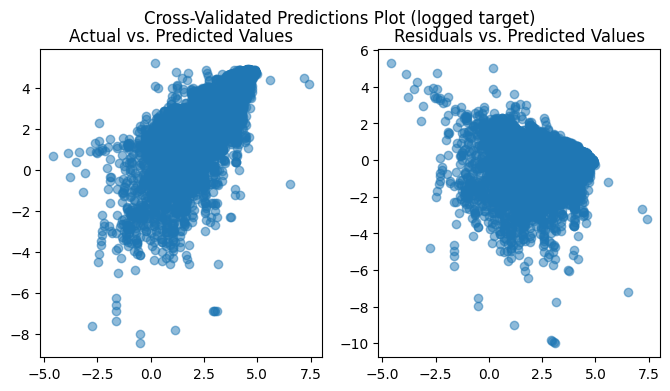

In [13]:
y_pred = cross_val_predict(regr2,X_Scaled,y_log,cv=10)

fig, axs = plt.subplots(ncols = 2,figsize = (8,4))
axs[0].scatter(x = y_pred, y = y_log,alpha = .5)
axs[0].set_title('Actual vs. Predicted Values')
axs[1].scatter(x = y_pred, y = (y_log.critical_temp - y_pred),alpha=.5)
axs[1].set_title('Residuals vs. Predicted Values')
fig.suptitle('Cross-Validated Predictions Plot (logged target)')

Text(0.5, 0.98, 'Cross-Validated Predictions Plot (logged target)')

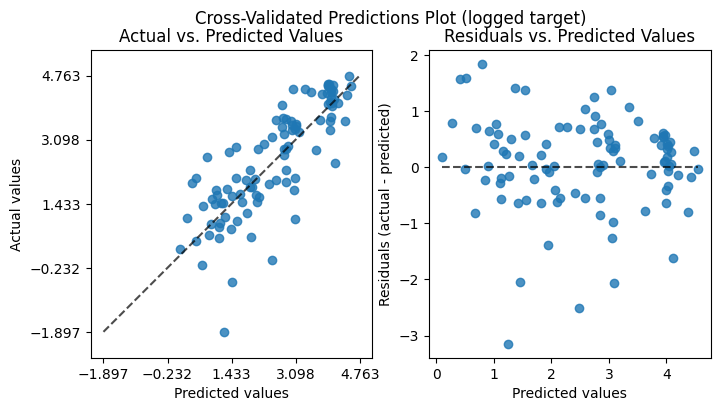

In [14]:
fig, axs = plt.subplots(ncols = 2, figsize = (8,4))
PredictionErrorDisplay.from_predictions(y_log.critical_temp
                                        ,y_pred=y_pred,
                                        kind="actual_vs_predicted",
                                        ax=axs[0],random_state=0,
                                        subsample = 100)
axs[0].set_title('Actual vs. Predicted Values')
PredictionErrorDisplay.from_predictions(y_log.critical_temp,
                                        y_pred=y_pred,
                                        kind="residual_vs_predicted",
                                        ax=axs[1],
                                        random_state=0,
                                        subsample = 100)
axs[1].set_title('Residuals vs. Predicted Values')
fig.suptitle('Cross-Validated Predictions Plot (logged target)')

Results from the gridsearch CV showed Ridge was selected for regularization.

In [15]:
regr2.n_features_in_

144

In [16]:
regr2.feature_names_in_

array(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass',
       'wtd_range_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie',
       'wtd_mean_fie', 'wtd_entropy_fie', 'range_fie', 'wtd_range_fie',
       'wtd_std_fie', 'mean_atomic_radius', 'wtd_mean_atomic_radius',
       'gmean_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'mean_Density', 'wtd_mean_Density',
       'gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity',
       'gmean_ElectronAffinity', 'wtd_gmean_ElectronAffinity',
       'entropy_ElectronAffinity', 'wtd_entropy_ElectronAffinity',
       'range_ElectronAffinity', 'wtd_range_ElectronAffinity',
       'wtd_std_ElectronAffinity', 'mean_FusionHeat',
       'wtd_mean_FusionHeat', 'gmean_FusionHeat', '

In [17]:
regr2.coef_

array([ 0.02448709,  0.        ,  0.        ,  0.        ,  0.        ,
        0.18789303,  0.02157998, -0.07756828,  0.        ,  0.        ,
        0.        ,  0.        ,  0.06182646,  0.        ,  0.        ,
        0.        ,  0.04483399, -0.01358716,  0.12894873,  0.01202781,
        0.        ,  0.        , -0.32014317,  0.        ,  0.        ,
        0.        ,  0.        , -0.01929801,  0.        ,  0.        ,
        0.        , -0.29981849,  0.        , -0.0075802 ,  0.        ,
       -0.02293687,  0.        ,  0.        ,  0.0594764 ,  0.13373011,
        0.06004577,  0.        ,  0.        ,  0.        , -0.00103391,
        0.04393498,  0.23528388,  0.        , -0.46443949,  0.        ,
        0.        ,  0.28248735, -0.06652014,  0.        ,  0.        ,
        0.        ,  0.10450368, -0.15217451, -0.01365737,  0.        ,
        0.02786538,  0.        , -0.03859922,  0.08375729, -0.01391538,
        0.01054712,  0.        ,  0.        ,  0.00136726,  0.02

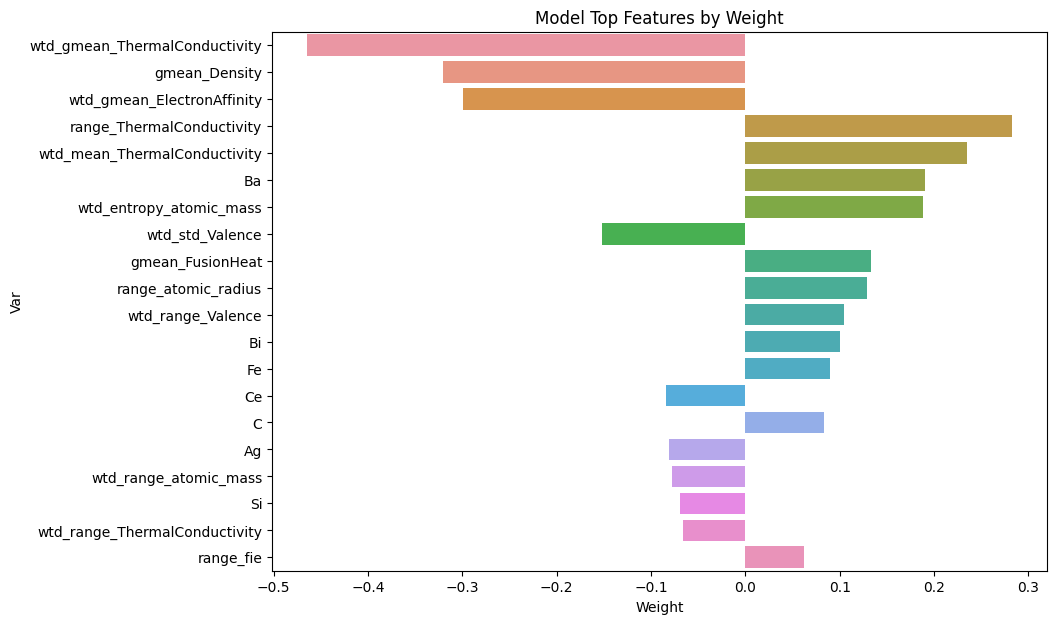

In [18]:
Weights = pd.Series(regr2.coef_, index = regr2.feature_names_in_)
Weights = pd.DataFrame({'Var':Weights.index, 'Weight':Weights.values})
Weights = Weights.sort_values('Weight')
idx = Weights['Weight'].abs().sort_values(ascending = False).head(20).index
Weights2 = Weights.loc[idx]
plt.figure(figsize=(10, 7))
sns.barplot(x='Weight', y = 'Var', data = Weights2,).set(title = "Model Top Features by Weight");

There were a number of variables included with a coefficient of 0.

In [19]:
#0 weight variables
Weights_drop = Weights[Weights["Weight"] == 0] 
Weights_drop

,Var,Weight
132,Re,0.0
131,W,0.0
134,Ir,0.0
86,Cu,0.0
82,Mn,0.0
...,...,...
66,F,0.0
3,gmean_atomic_mass,0.0
59,He,0.0
61,Be,0.0


Text(0, 0.5, 'Mean Absolute Error')

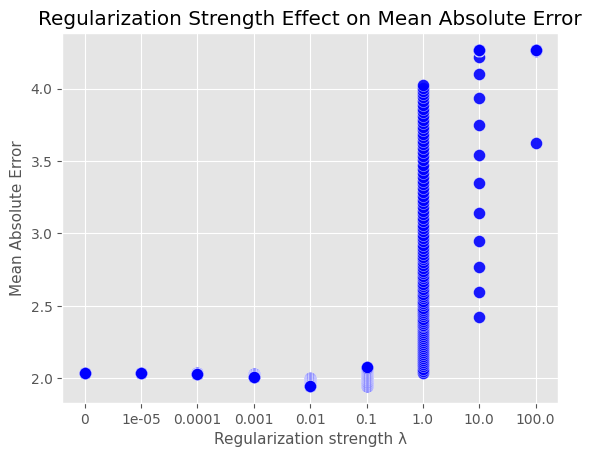

In [20]:
# Regularization strength error plot (from grid search, probably best not to use this one)
score = pd.DataFrame(results2.cv_results_)
plt.style.use('ggplot')
plt.scatter(x=score.param_alpha.astype('str'),
            y=np.exp(score.mean_test_score*-1),
            c = 'blue',
            edgecolors='white',
            linewidths=.3,alpha=.9,
            s = 75)
plt.title('Regularization Strength Effect on Mean Absolute Error')
plt.xlabel('Regularization strength λ',fontsize = 11)

plt.ylabel('Mean Absolute Error',fontsize =11)

In [21]:
rng = np.random.default_rng(51323)
rseeds = rng.integers(low=0, high = 1000, size = 10)

mae_holder = []
alpha_holder = []
for k in rseeds:
  for j in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]:
    regr3 = Lasso(random_state=k, alpha=j,max_iter=3000)

    i=0

    # Create a 10-fold cross-validation 
    cv = KFold(n_splits = 10, 
              shuffle = True, 
              random_state = k)

    MAE = []

    #i=0
    for train, test in cv.split(X_Scaled, y_log):
        X_train, X_test = X_Scaled.iloc[train], X_Scaled.iloc[test]
        y_train, y_test = y_log.iloc[train], y_log.iloc[test]

        X_train, y_train = make_regression(n_features=2, random_state=0)
        
        regr3.fit(X_Scaled, y_log)

        # Predict 
        y_pred_lin_reg = regr3.predict(X_test)
      
        # Calculate  mean squared error
        lin_MAE_reg= metrics.mean_absolute_error(y_test, y_pred_lin_reg)

        i=i+1
        # Append to the list
        mae_holder.append(lin_MAE_reg)
        alpha_holder.append(j)

In [22]:
a_err =pd.DataFrame({'alpha':alpha_holder,'MAE':np.exp(mae_holder)})
a_err.groupby('alpha').describe()

MAE                                                              \
           count      mean       std       min       25%       50%       75%   
alpha                                                                          
0.00001    100.0  1.778179  0.020904  1.739901  1.762823  1.778776  1.791805   
0.00010    100.0  1.778238  0.020866  1.740255  1.763275  1.778433  1.791804   
0.00100    100.0  1.782970  0.020619  1.743417  1.770297  1.781596  1.796669   
0.01000    100.0  1.832520  0.021719  1.783576  1.818789  1.834269  1.845433   
0.10000    100.0  2.002426  0.026968  1.933229  1.986887  2.003031  2.018575   
1.00000    100.0  3.342390  0.063510  3.163736  3.296809  3.342570  3.384061   
10.00000   100.0  3.608693  0.071487  3.413379  3.555847  3.609612  3.657724   
100.00000  100.0  3.608693  0.071487  3.413379  3.555847  3.609612  3.657724   

                     
                max  
alpha                
0.00001    1.826655  
0.00010    1.826722  
0.00100    1.831070  
0.01000    1.881587  
0.10000    2.083687  
1.00000    3.522891  
10.00000   3.806905  
100.00000  3.806905

Text(0, 0.5, 'Mean Absolute Error')

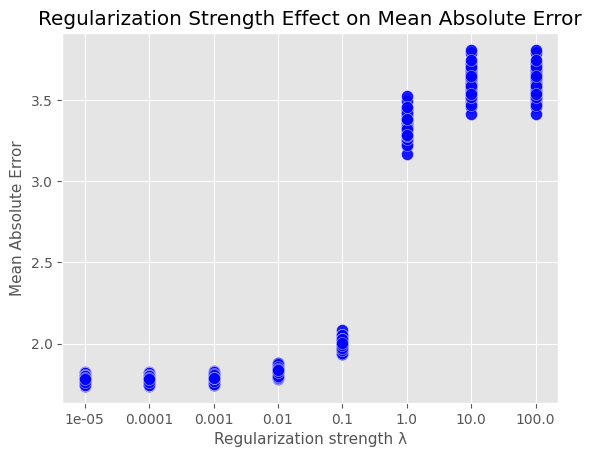

In [23]:
# Regularization strength error plot (8 different alphas, 10-fold, 10 times each)
plt.style.use('ggplot')
plt.scatter(x=list(map(str,alpha_holder)),
            y=np.exp(mae_holder),
            c = 'blue',
            edgecolors='white',
            linewidths=.3,alpha=.9,
            s = 75)
plt.title('Regularization Strength Effect on Mean Absolute Error')
plt.xlabel('Regularization strength λ',fontsize = 11)

plt.ylabel('Mean Absolute Error',fontsize =11)